<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>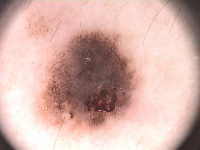</td><td>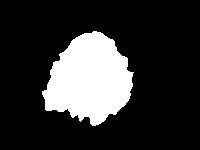</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# Замечание: я работал с ноутбуком на каггле, поэтому некоторые команды характерны именно для каггла. ПРосьба иметь это в виду при проверке. Спасио!

In [ ]:
# !gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [17]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

In [18]:
# Установка распаковщика
# !apt-get install unrar -y

In [4]:
# Проверим, что датасет на месте
!ls /kaggle/input

ph2dataset


In [3]:
# Проверим и папку PH2Dataset - д.б. внутри ph2dataset 
!ls /kaggle/input/ph2dataset/

PH2Dataset


In [4]:
# Содержимое
!ls /kaggle/input/ph2dataset/PH2Dataset/

'PH2 Dataset images'   PH2_dataset.txt	 PH2_dataset.xlsx   Readme.txt


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [5]:
images = []
lesions = []
from skimage.io import imread
import os

# Скорректируем пут к датасету(т.к. это каггл)
# root = 'PH2Dataset'
root = '/kaggle/input/ph2dataset/PH2Dataset'



for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [6]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

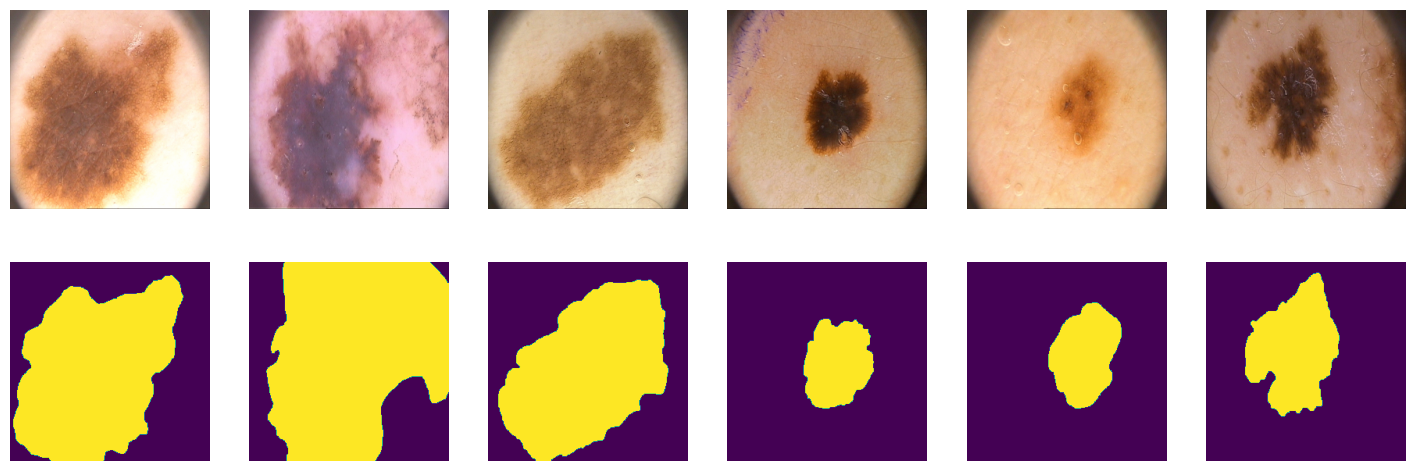

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [17]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [13]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

In [ ]:
# Пусть:
# y1 - игрек(без крышки), т.е. истинная метка(таргет результата)
# y2 - игрек с крышкой, т.е. логит
#
# Вспомним ф-ю сигмоиды:
# 1) sigm(y2) = 1 / (1 + e ** -y2)
# 2) 1 - sigm(y2) = (e ** -y2) / (1 + e ** -y2)
#
# Подставим значения в исх.формулу вместо сигм:
# [1] = -[y1 * log(1 / (1 + e ** -y2)) + (1 - y1) * log((e ** -y2) / (1 + e ** -y2))]
#
# Применим свойство логарифма частного, и перепишем:
# [1] = -[y1 * (-log(1 + e ** -y2)) + (1 - y) * (-y2 - log(1 + e ** -y2))]
#
# Избавляемся от минуса в начале выражения, перегруппировываем члены и сразу получаем формулу [2]:
# [1] = (1 - y1) * y2 + (y1 + 1 - y1) * log(1 + e ** -y2) = y2 - y1 * y2 + log(1 + e ** -y2) = [2]

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [14]:
import torch.nn.functional as F
import torch.nn as nn

In [16]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [17]:
def bce_true(y_pred, y_real):
    sigmoid = torch.sigmoid(y_pred)
    loss = - (y_real * torch.log(sigmoid + 1e-15) + (1 - y_real) * torch.log(1 - sigmoid + 1e-15))
    return torch.sum(loss)

def bce_loss(y_pred, y_real):
    loss = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    return torch.sum(loss)

Проверим корректность работы на простом примере

In [18]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 4.1355180740356445
BCE loss честно посчитанный = 4.135517597198486
BCE loss from torch bce_torch = 4.135517597198486
BCE loss from torch with logits bce_torch = 4.135517597198486


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [21]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [22]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 14.35172176361084
BCE loss честно посчитанный = 14.351720809936523
BCE loss from torch bce_torch = 14.351720809936523
BCE loss from torch with logits bce_torch = 14.35172176361084


In [23]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [28]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /kaggle/working/for_asserts/labels.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 4.94MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /kaggle/working/for_asserts/logits.pt
100%|██████████████████████████████████████| 1.18k/1.18k [00:00<00:00, 6.69MB/s]
Download completed


In [24]:
!ls

for_asserts


In [25]:
# path_to_dummy_samples = '/content/for_asserts'
path_to_dummy_samples = '/kaggle/working/for_asserts'

# Корректируем, т.е. явно указываем "weights_only=True", чтоб не выскакивали предупреждения
# dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
#                  'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt', weights_only=True),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt', weights_only=True)}


dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

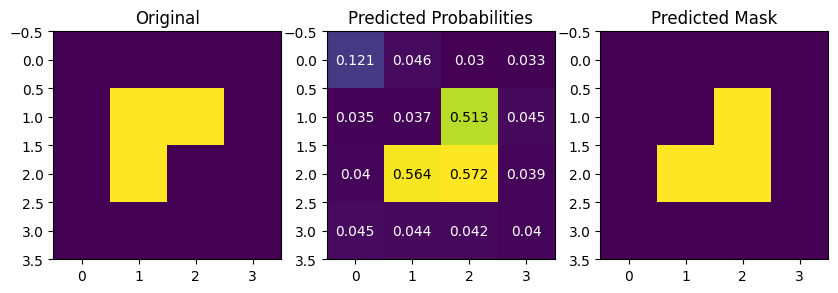

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [27]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

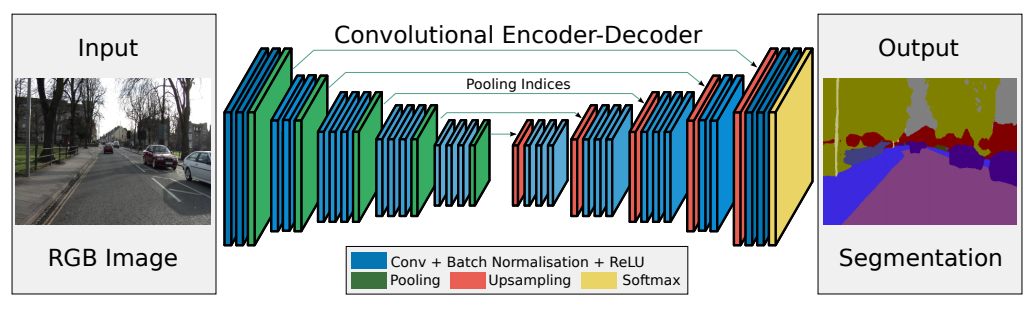

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [31]:
# class SegNet(nn.Module):
#     def __init__(self, in_channels=3, out_channels=1):
#         super().__init__()
# 
#         # VGG-16 architecture
#         # TODO
# 
#         # bottleneck
#         # TODO
# 
#         # decoder (upsampling)
#         # TODO
# 
#     def forward(self, x):
#         # encoder
#         # TODO
# 
#         # bottleneck
#         # TODO
# 
#         # decoder
#         # TODO
# 
#         return output # no activation

In [ ]:
# Архитектура взятая с просторов Интернета. Вроде бы более сложная, но результаты обучения по ней - хуже, 
# чем у более простой(будет в след блоке), взятой по ссылке выше(https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239).
# (Хуже в том смысле, что обучение менее стабильное получается, метрики сильно ломаны и их максимальные значения не лучше). 
# 
# class SegNet(nn.Module):
#     def __init__(self, in_channels=3, out_channels=1):
#         super(SegNet, self).__init__()

#         # Encoder (VGG-16 based)
#         self.encoder_conv0 = nn.Sequential(
#             nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True)
#         )
#         self.encoder_pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

#         self.encoder_conv1 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True)
#         )
#         self.encoder_pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

#         self.encoder_conv2 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True)
#         )
#         self.encoder_pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

#         self.encoder_conv3 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True)
#         )
#         self.encoder_pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

#         # Bottleneck
#         self.bottleneck_conv = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True)
#         )
#         self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

#         # Decoder
#         self.decoder_unpool0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
#         self.decoder_conv0 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True)
#         )

#         self.decoder_unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
#         self.decoder_conv1 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True)
#         )

#         self.decoder_unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
#         self.decoder_conv2 = nn.Sequential(
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True)
#         )

#         self.decoder_unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
#         self.decoder_conv3 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True)
#         )

#         self.decoder_unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
#         self.decoder_conv4 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
#         )

#     def forward(self, x):
#         # Encoder
#         x = self.encoder_conv0(x)
#         x, idx0 = self.encoder_pool0(x)

#         x = self.encoder_conv1(x)
#         x, idx1 = self.encoder_pool1(x)

#         x = self.encoder_conv2(x)
#         x, idx2 = self.encoder_pool2(x)

#         x = self.encoder_conv3(x)
#         x, idx3 = self.encoder_pool3(x)

#         # Bottleneck
#         x = self.bottleneck_conv(x)
#         x, idx4 = self.bottleneck_pool(x)

#         # Decoder
#         x = self.decoder_unpool0(x, idx4)
#         x = self.decoder_conv0(x)

#         x = self.decoder_unpool1(x, idx3)
#         x = self.decoder_conv1(x)

#         x = self.decoder_unpool2(x, idx2)
#         x = self.decoder_conv2(x)

#         x = self.decoder_unpool3(x, idx1)
#         x = self.decoder_conv3(x)

#         x = self.decoder_unpool4(x, idx0)
#         x = self.decoder_conv4(x)

#         return x

In [ ]:
# Архитектура взята по ссылке из ноутбука 
# https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239

class SegNet(nn.Module): 
    def __init__(self, in_channels=3, out_channels=1, features=64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 2)
        self.enc2 = EncoderBlock(features * 2, features * 4, depth=3)
        self.enc3 = EncoderBlock(features * 4, features * 8, depth=3)

        # Bottleneck
        self.bottleneck_enc = EncoderBlock(features * 8, features * 8, depth=3) 
        self.bottleneck_dec = DecoderBlock(features * 8, features * 8, depth=3) 

        # Decoder
        self.dec0 = DecoderBlock(features * 8, features * 4, depth=3)
        self.dec1 = DecoderBlock(features * 4, features * 2, depth=3)
        self.dec2 = DecoderBlock(features * 2, features)
        self.dec3 = DecoderBlock(features, out_channels, classification=True) # No activation

    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x) 
        e1, ind1 = self.enc1(e0) 
        e2, ind2 = self.enc2(e1) 
        e3, ind3 = self.enc3(e2)

        # bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)

        # decoder
        d0 = self.dec0(b1, ind3)
        d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d1, ind1)

        # classification layer
        output = self.dec3(d2, ind0)  
        return output

class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1) -> None:
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_c if i == 0 else out_c, out_c, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, ind = self.pool(x)
        return x, ind

class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1, classification=False) -> None:
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_c, out_c, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvReLU(in_c, in_c, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.layers:
            x = layer(x)
        return x

import torch.nn as nn

class ConvReLU(nn.Module):
  def __init__(self, in_c, out_c, kernel_size=3, padding=1) -> None:
      super(ConvReLU, self).__init__()
      self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
      self.bn = nn.BatchNorm2d(out_c)
      self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
      x = self.conv(x)
      x = self.bn(x)
      x = self.relu(x)
      return x

In [40]:
segnet_model = SegNet().to(device)

In [41]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [42]:
from tqdm.notebook import tqdm

In [43]:
# def train(...):
#   # TODO

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=25, device='cpu'):
    best_iou = 0.0
    train_loss_history = []
    val_loss_history = []
    iou_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        iou_score = 0.0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item() * inputs.size(0)

                # Calculate IoU
                preds = torch.sigmoid(outputs) > 0.5
                iou = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
                iou_score += iou(preds, labels.byte()) * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_loss_history.append(val_loss)

        iou_score /= len(val_loader.dataset)
        iou_history.append(iou_score)

        print(f'Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, IoU: {iou_score:.4f}')

        # Save best model
        if iou_score > best_iou:
            best_iou = iou_score
            torch.save(model.state_dict(), 'best_segnet_model.pth')
            print('Model saved!')

    print(f'Best IoU: {best_iou:.4f}')

    return {
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'iou_history': iou_history,
        'best_iou': best_iou
    }

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [44]:
# # TODO
# train(...)

from torch.optim import Adam
optimizer = Adam(segnet_model.parameters(), lr=1e-3)

# Ранее определенные лоссфункции
# criterion = bce_torch
criterion = bce_torch_with_logits #BCEWithLogitsLoss
# criterion = bce_true
# criterion = bce_loss

history = train(
    model=segnet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=25,
    device=device
)

Epoch 1/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 1096134.0312, Val Loss: 1126404.7500, IoU: 0.0000
Epoch 2/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 776155.2188, Val Loss: 1073477.6875, IoU: 0.0000
Epoch 3/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 563264.7266, Val Loss: 1122290.6875, IoU: 0.0066
Model saved!
Epoch 4/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 448735.2891, Val Loss: 1241364.3750, IoU: 0.1877
Model saved!
Epoch 5/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 386274.6094, Val Loss: 1500090.5625, IoU: 0.0856
Epoch 6/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 442988.9062, Val Loss: 1175749.8125, IoU: 0.0741
Epoch 7/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 374478.8594, Val Loss: 968269.8125, IoU: 0.3592
Model saved!
Epoch 8/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 412018.5234, Val Loss: 1209511.1250, IoU: 0.3642
Model saved!
Epoch 9/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 388907.1953, Val Loss: 710374.0625, IoU: 0.4844
Model saved!
Epoch 10/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 384197.3750, Val Loss: 621811.5312, IoU: 0.6013
Model saved!
Epoch 11/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 363721.8125, Val Loss: 530487.4219, IoU: 0.6631
Model saved!
Epoch 12/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 354624.3125, Val Loss: 484149.4375, IoU: 0.6832
Model saved!
Epoch 13/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 323178.1562, Val Loss: 489233.3750, IoU: 0.6904
Model saved!
Epoch 14/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 341481.7930, Val Loss: 490331.5312, IoU: 0.6786
Epoch 15/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 309701.1797, Val Loss: 452645.2031, IoU: 0.7380
Model saved!
Epoch 16/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 320574.7031, Val Loss: 389209.8438, IoU: 0.7505
Model saved!
Epoch 17/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 310613.2734, Val Loss: 518311.0625, IoU: 0.6402
Epoch 18/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 338131.3125, Val Loss: 496467.1250, IoU: 0.6767
Epoch 19/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 315957.8047, Val Loss: 381746.7188, IoU: 0.7811
Model saved!
Epoch 20/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 335213.6133, Val Loss: 428206.3125, IoU: 0.7743
Epoch 21/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 299039.4062, Val Loss: 376770.5000, IoU: 0.7766
Epoch 22/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 292786.4297, Val Loss: 393556.7812, IoU: 0.7681
Epoch 23/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 283940.7383, Val Loss: 417521.9375, IoU: 0.7329
Epoch 24/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 280625.4023, Val Loss: 397581.9844, IoU: 0.7629
Epoch 25/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 303633.8164, Val Loss: 425448.3438, IoU: 0.7740
Best IoU: 0.7811


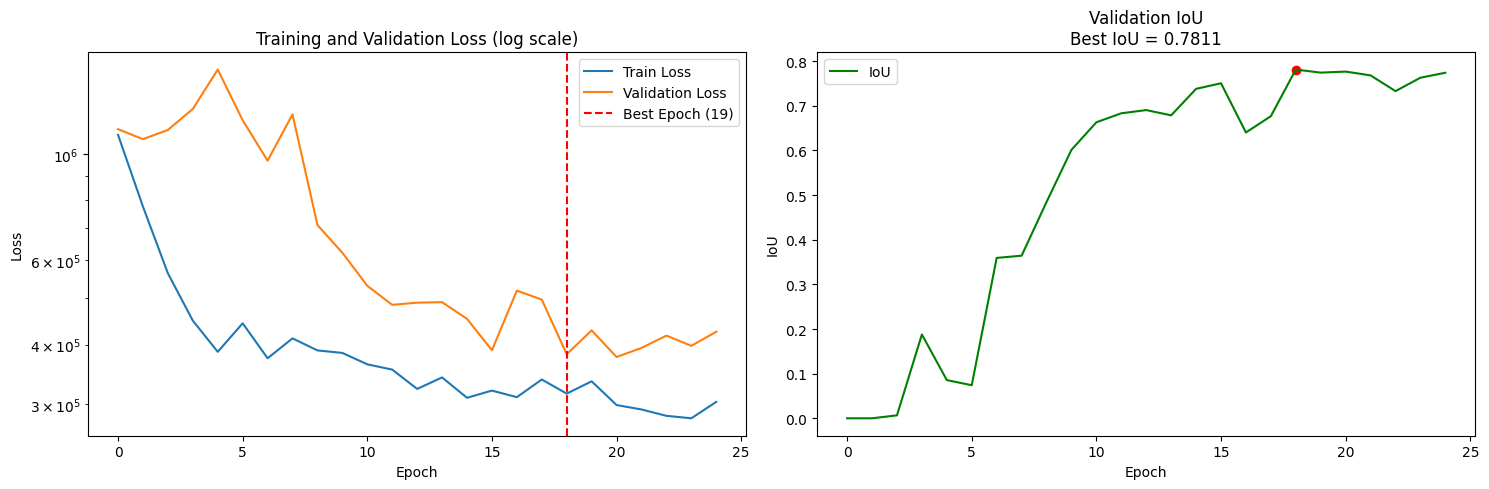

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_numpy(data):
    """Приводит данные (включая списки/массивы тензоров) к NumPy-массиву."""
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()
    elif isinstance(data, (list, tuple)) and all(isinstance(d, torch.Tensor) for d in data):
        return np.array([d.detach().cpu().item() for d in data])
    return np.array(data)

def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    train_loss = to_numpy(history['train_loss_history'])
    val_loss = to_numpy(history['val_loss_history'])
    iou_history = to_numpy(history['iou_history'])

    # Потери
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss (log scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    best_epoch = np.argmax(iou_history)
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    plt.legend()

    # IoU
    plt.subplot(1, 2, 2)
    plt.plot(iou_history, label='IoU', color='green')
    plt.scatter(best_epoch, iou_history[best_epoch], color='red')
    best_iou = iou_history[best_epoch]
    plt.title(f'Validation IoU\nBest IoU = {best_iou:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [39]:
# В целом, обучение получилось вполне себе стабильное с неплохой IoU=0.7811.

## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [46]:
# def test(...):
#   # TODO

# def test(model, test_loader, criterion, device='cpu'):
#     model.eval()
#     test_loss = 0.0
#     iou_score = 0.0

#     with torch.no_grad():
#         for inputs, labels in tqdm(test_loader, desc='Testing'):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             test_loss += criterion(outputs, labels).item() * inputs.size(0)

#             # Calculate IoU
#             preds = torch.sigmoid(outputs) > 0.5
#             iou = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
#             iou_score += iou(preds, labels.byte()) * inputs.size(0)

#     test_loss /= len(test_loader.dataset)
#     iou_score /= len(test_loader.dataset)

#     print(f'Test Loss: {test_loss:.4f}, IoU: {iou_score:.4f}')

#     return test_loss, iou_score


def test(model, test_loader, criterion, device='cpu'):
    model.eval()
    test_loss = 0.0
    iou_metric = JaccardIndex(threshold=0.5, task="binary", average='micro').to(device)

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).int()
            iou_metric.update(preds, labels.int())

    test_loss /= len(test_loader.dataset)
    test_iou = iou_metric.compute().item()

    print(f'Test Loss: {test_loss:.4f}, IoU: {test_iou:.4f}')
    return test_loss, test_iou

In [47]:
# test(...)

# Загрузка лучшей модели
state_dict = torch.load('best_segnet_model.pth', weights_only=True)  # безопасный способ
segnet_model.load_state_dict(state_dict)


# Тестирование
test_loss, test_iou = test(
    model=segnet_model,
    test_loader=test_dataloader,
    criterion=criterion,
    device=device
)

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 393584.2500, IoU: 0.7756


In [48]:
print(f"Best Val IoU: {history['best_iou']:.4f}")
print(f"Test IoU: {test_iou:.4f}")

Best Val IoU: 0.7811
Test IoU: 0.7756


In [ ]:
# В целом, разница между лучшим валидационным IoU (0.7811) и тестовым IoU (0.7756) составляет 0.0055, что указывает на умеренное переобучение.
# Наверняка, "покрутив" модельку и параметры, можно улучшить целевые показатели(в задании не требуется), в т.ч. через аугментацию, 
# регуляризацию, нормализацию и м.б. чего-то ещё.

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [49]:
# def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
#     '''
#     Это именно метрика, не лосс.
#     '''
#     # TODO
# 
#     return score

def dice_score(logits: torch.Tensor, labels: torch.Tensor, epsilon: float = 1e-8):
    probs = torch.sigmoid(logits)
    labels = labels.float()
    intersection = (probs * labels).sum()
    union = probs.sum() + labels.sum()
    return (2 * intersection + epsilon) / (union + epsilon)

Проверим на корректность функцию dice_score:

In [50]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.4244, device='cuda:0')

In [ ]:
'''
если вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():

from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)

'''

In [51]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [52]:
# def dice_loss(logits: torch.Tensor, labels: torch.Tensor):
# 
#     '''
#     Это лосс.
#     '''
#     # TODO
# 
#     return loss

def dice_loss(logits: torch.Tensor, labels: torch.Tensor):
    epsilon = 1e-8
    pred = torch.sigmoid(logits)
    tp = (pred * labels).sum()
    fp = (pred * (1 - labels)).sum()
    fn = ((1 - pred) * labels).sum()

    return 1 - (2 * tp + epsilon) / (2 * tp + fp + fn + epsilon)

Проверка на корректность:

In [53]:
# проверьте, что у вас установлена библиотека
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.4 MB/s eta 0:00:00


In [54]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [55]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [70]:
# def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
#     # TODO
# 
#     return loss

def focal_loss(y_pred, y_real, eps=1e-8, gamma=2.0):
    pred = torch.sigmoid(y_pred)
    y_real = y_real.float()

    # pt — вероятность правильного класса
    p_t = pred * y_real + (1 - pred) * (1 - y_real)
    focal_factor = (1 - p_t) ** gamma

    bce_loss = -(y_real * torch.log(pred + eps) + (1 - y_real) * torch.log(1 - pred + eps))

    # итоговый focal loss
    loss = (focal_factor * bce_loss).sum()
    return loss

Проверка корректности функции:

In [57]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [71]:
# assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

# У меня в этой строке возникают ошибки, поэтому ее закомментим и разберемся детально

# исх.выражение:
# assert sigmoid_focal_loss(
#     dummpy_sample['logits'], 
#     dummpy_sample['labels'], 
#     alpha=-1, 
#     gamma=2, 
#     reduction='sum') == focal_loss(
#                             dummpy_sample['labels'], 
#                             dummpy_sample['logits'], 
#                             gamma=2.0)

logits = dummpy_sample['logits']
labels = dummpy_sample['labels'].float()

torchvision_loss = sigmoid_focal_loss(logits, labels, alpha=-1, gamma=2.0, reduction='sum')
custom_loss = focal_loss(logits, labels, gamma=2.0)

print(f"Torchvision: {torchvision_loss.item():.6f}")
print(f"Custom:      {custom_loss.item():.6f}")

print(type(torchvision_loss))  # torch.Tensor
print(type(custom_loss))       # torch.Tensor

Torchvision: 3.616124
Custom:      3.616123
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [59]:
# Разница
print(abs(torchvision_loss.item() - custom_loss.item()))

2.384185791015625e-07


In [62]:
# Поскольку Torchvision и Custom не равны, то этим и объясняется ошибка в строке из исх.выражения:
#                   assert sigmoid_focal_loss(..)==focal_loss(..), или эквивалентного assert torchvision_loss == custom_loss
# 
# В таких ситуациях правильнее сравнивать через torch.allclose()
# Например: assert torch.allclose(torchvision_loss, custom_loss, atol= 1e-6), "Focal Loss mismatch!"
# или так:

diff = abs(torchvision_loss.item() - custom_loss.item())
# tolerance = 1.3e-07 # не равны
tolerance = 1e-6 # равын

if diff > tolerance:
    print(f"Лоссы не равны! Разница: {diff:.10f} > {tolerance}")
else:
    print(f"Лоссы равны. Разница: {diff:.10f} <= {tolerance}")

Лоссы равны. Разница: 0.0000002384 <= 1e-06


## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [75]:
def tversky_loss(y_pred, y_true, alpha=0.7, beta=0.3, eps=1e-8):
   
    probs = torch.sigmoid(y_pred)
    y_true = y_true.float()
    
    tp = (probs * y_true).sum()
    fp = (probs * (1 - y_true)).sum()
    fn = ((1 - probs) * y_true).sum()
    
    return 1 - (tp + eps) / (tp + alpha*fp + beta*fn + eps)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [65]:
# Лоссфункция dice_loss
criterion = dice_loss

segnet_model = SegNet().to(device)

from torch.optim import Adam
optimizer = Adam(segnet_model.parameters(), lr=1e-3, weight_decay=1e-4)

history = train(
    model=segnet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=25,
    device=device
)

Epoch 1/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6385, Val Loss: 0.5735, IoU: 0.0005
Model saved!
Epoch 2/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5845, Val Loss: 0.5626, IoU: 0.3768
Model saved!
Epoch 3/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5134, Val Loss: 0.5222, IoU: 0.3769
Model saved!
Epoch 4/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4863, Val Loss: 0.4495, IoU: 0.3772
Model saved!
Epoch 5/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4773, Val Loss: 0.4525, IoU: 0.3768
Epoch 6/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4085, Val Loss: 0.4539, IoU: 0.3772
Epoch 7/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3622, Val Loss: 0.4172, IoU: 0.4198
Model saved!
Epoch 8/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3384, Val Loss: 0.3587, IoU: 0.4837
Model saved!
Epoch 9/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2874, Val Loss: 0.4091, IoU: 0.4170
Epoch 10/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2557, Val Loss: 0.4414, IoU: 0.3852
Epoch 11/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2340, Val Loss: 0.5069, IoU: 0.3254
Epoch 12/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2073, Val Loss: 0.1999, IoU: 0.6867
Model saved!
Epoch 13/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2000, Val Loss: 0.1704, IoU: 0.7352
Model saved!
Epoch 14/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2043, Val Loss: 0.2061, IoU: 0.6767
Epoch 15/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1729, Val Loss: 0.1683, IoU: 0.7389
Model saved!
Epoch 16/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1729, Val Loss: 0.1557, IoU: 0.7535
Model saved!
Epoch 17/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1743, Val Loss: 0.1626, IoU: 0.7400
Epoch 18/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1411, Val Loss: 0.1934, IoU: 0.6909
Epoch 19/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1529, Val Loss: 0.1895, IoU: 0.6969
Epoch 20/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1503, Val Loss: 0.1695, IoU: 0.7241
Epoch 21/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1701, Val Loss: 0.1676, IoU: 0.7251
Epoch 22/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1589, Val Loss: 0.2728, IoU: 0.5765
Epoch 23/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1837, Val Loss: 0.2299, IoU: 0.6329
Epoch 24/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1746, Val Loss: 0.4064, IoU: 0.4270
Epoch 25/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1877, Val Loss: 0.9861, IoU: 0.0001
Best IoU: 0.7535


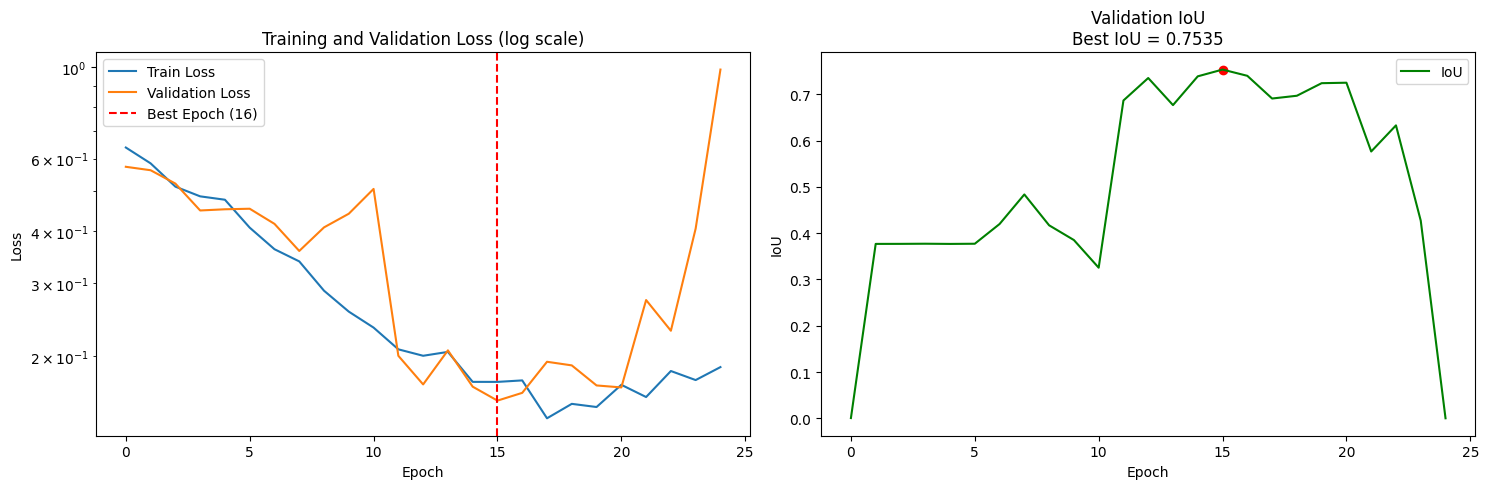

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_numpy(data):
    """Приводит данные (включая списки/массивы тензоров) к NumPy-массиву."""
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()
    elif isinstance(data, (list, tuple)) and all(isinstance(d, torch.Tensor) for d in data):
        return np.array([d.detach().cpu().item() for d in data])
    return np.array(data)

def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    train_loss = to_numpy(history['train_loss_history'])
    val_loss = to_numpy(history['val_loss_history'])
    iou_history = to_numpy(history['iou_history'])

    # Потери
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss (log scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    best_epoch = np.argmax(iou_history)
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    plt.legend()

    # IoU
    plt.subplot(1, 2, 2)
    plt.plot(iou_history, label='IoU', color='green')
    plt.scatter(best_epoch, iou_history[best_epoch], color='red')
    best_iou = iou_history[best_epoch]
    plt.title(f'Validation IoU\nBest IoU = {best_iou:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Лучшие показатели Max IoU: 0.7535 (16 эпоха) и Val Loss: 0.1557 (минимум). Далее(эпохи 18-25) - наблюдается деградация, причем Val Loss растёт(с 0.1934 к 0.9861),
# IoU падает до 0.0001 на последней эпохе. Возможные причины: переобучение (несмотря на рост val loss с 16 эпохи), слишком высокий learning rate, какие-то другие проблемы.

In [72]:
# Лоссфункция focal_loss
criterion = focal_loss

segnet_model = SegNet().to(device)

from torch.optim import Adam
optimizer = Adam(segnet_model.parameters(), lr=1e-3, weight_decay=1e-4)

history = train(
    model=segnet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=25,
    device=device
)

Epoch 1/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 253591.5938, Val Loss: 276441.8438, IoU: 0.0000
Epoch 2/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 219581.9922, Val Loss: 273417.7188, IoU: 0.0001
Model saved!
Epoch 3/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 195100.9805, Val Loss: 235382.1406, IoU: 0.6047
Model saved!
Epoch 4/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 141156.2207, Val Loss: 369277.1250, IoU: 0.0999
Epoch 5/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 117434.4316, Val Loss: 432929.7188, IoU: 0.1342
Epoch 6/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 109407.1641, Val Loss: 460399.5781, IoU: 0.2301
Epoch 7/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 107960.7676, Val Loss: 619918.4688, IoU: 0.4282
Epoch 8/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 104148.2910, Val Loss: 216906.7500, IoU: 0.5086
Epoch 9/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 93408.1738, Val Loss: 165996.4375, IoU: 0.6356
Model saved!
Epoch 10/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 92129.4180, Val Loss: 170423.4375, IoU: 0.6453
Model saved!
Epoch 11/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 97566.5039, Val Loss: 161610.3594, IoU: 0.6521
Model saved!
Epoch 12/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 86477.8457, Val Loss: 132218.8906, IoU: 0.7135
Model saved!
Epoch 13/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 95006.6582, Val Loss: 125770.6641, IoU: 0.7155
Model saved!
Epoch 14/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 85205.2207, Val Loss: 128030.6328, IoU: 0.7301
Model saved!
Epoch 15/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 83448.8086, Val Loss: 122127.5156, IoU: 0.7462
Model saved!
Epoch 16/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 77047.4688, Val Loss: 234864.6016, IoU: 0.6284
Epoch 17/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 77910.0391, Val Loss: 144926.2383, IoU: 0.7263
Epoch 18/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 78903.5703, Val Loss: 140046.3047, IoU: 0.6952
Epoch 19/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 88597.0098, Val Loss: 111534.8555, IoU: 0.7517
Model saved!
Epoch 20/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 69967.9062, Val Loss: 112895.5664, IoU: 0.7458
Epoch 21/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 79419.0400, Val Loss: 137727.5000, IoU: 0.7332
Epoch 22/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 68083.1992, Val Loss: 133392.5547, IoU: 0.7481
Epoch 23/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 68721.0918, Val Loss: 139250.6250, IoU: 0.7269
Epoch 24/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 70402.7373, Val Loss: 142415.2969, IoU: 0.7123
Epoch 25/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 71550.2061, Val Loss: 139127.2656, IoU: 0.7174
Best IoU: 0.7517


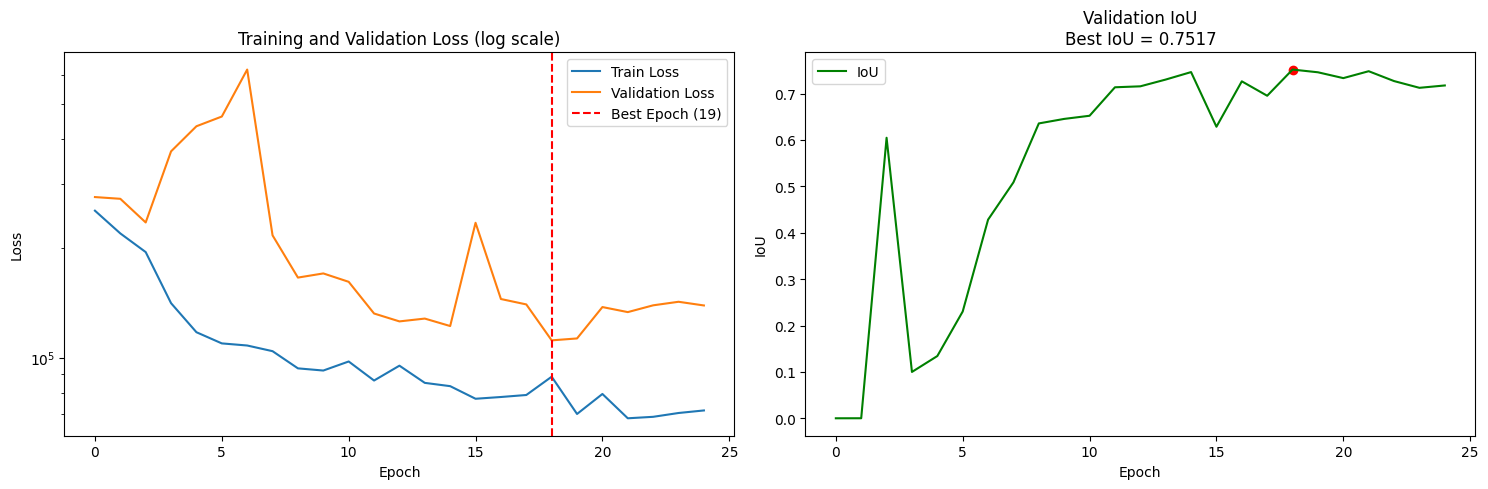

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_numpy(data):
    """Приводит данные (включая списки/массивы тензоров) к NumPy-массиву."""
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()
    elif isinstance(data, (list, tuple)) and all(isinstance(d, torch.Tensor) for d in data):
        return np.array([d.detach().cpu().item() for d in data])
    return np.array(data)

def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    train_loss = to_numpy(history['train_loss_history'])
    val_loss = to_numpy(history['val_loss_history'])
    iou_history = to_numpy(history['iou_history'])

    # Потери
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss (log scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    best_epoch = np.argmax(iou_history)
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    plt.legend()

    # IoU
    plt.subplot(1, 2, 2)
    plt.plot(iou_history, label='IoU', color='green')
    plt.scatter(best_epoch, iou_history[best_epoch], color='red')
    best_iou = iou_history[best_epoch]
    plt.title(f'Validation IoU\nBest IoU = {best_iou:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# На 3-й эпохе меть находит хорошее решение, которое улучшается вплоть до 8-10-й эпох. Далее постепенный 
# рост IoU (с 0.6356 до 0.7462). Далее IoT сравнительно стабильна(в отличие от dice_loss). 
# Focal Loss показал более стабильное обучение по сравнению с Dice Loss, достигнув сопоставимого качества (IoU 0.7517), но зато без резких деградаций.

In [78]:
# Лоссфункция tversky_loss
criterion = tversky_loss

segnet_model = SegNet().to(device)

from torch.optim import Adam
optimizer = Adam(segnet_model.parameters(), lr=1e-3, weight_decay=1e-4)

history = train(
    model=segnet_model,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=25,
    device=device
)

Epoch 1/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6596, Val Loss: 0.5912, IoU: 0.3768
Model saved!
Epoch 2/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.5326, Val Loss: 0.4552, IoU: 0.5355
Model saved!
Epoch 3/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.4512, Val Loss: 0.4808, IoU: 0.4448
Epoch 4/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3933, Val Loss: 0.4342, IoU: 0.4388
Epoch 5/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3260, Val Loss: 0.6237, IoU: 0.1369
Epoch 6/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2509, Val Loss: 0.4073, IoU: 0.3378
Epoch 7/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.2227, Val Loss: 0.3195, IoU: 0.4347
Epoch 8/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1959, Val Loss: 0.2541, IoU: 0.5208
Epoch 9/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1595, Val Loss: 0.2291, IoU: 0.5741
Model saved!
Epoch 10/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1628, Val Loss: 0.2345, IoU: 0.5231
Epoch 11/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1473, Val Loss: 0.2155, IoU: 0.5687
Epoch 12/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1373, Val Loss: 0.1836, IoU: 0.5856
Model saved!
Epoch 13/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1216, Val Loss: 0.1708, IoU: 0.6080
Model saved!
Epoch 14/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1253, Val Loss: 0.1455, IoU: 0.6547
Model saved!
Epoch 15/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1157, Val Loss: 0.1494, IoU: 0.6436
Epoch 16/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1213, Val Loss: 0.1718, IoU: 0.5997
Epoch 17/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1030, Val Loss: 0.1418, IoU: 0.6624
Model saved!
Epoch 18/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1082, Val Loss: 0.1424, IoU: 0.6553
Epoch 19/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1429, Val Loss: 0.1490, IoU: 0.7064
Model saved!
Epoch 20/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1347, Val Loss: 0.1857, IoU: 0.6066
Epoch 21/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1270, Val Loss: 0.1772, IoU: 0.7024
Epoch 22/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1208, Val Loss: 0.2965, IoU: 0.5910
Epoch 23/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1066, Val Loss: 0.3344, IoU: 0.5638
Epoch 24/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1004, Val Loss: 0.1882, IoU: 0.7082
Model saved!
Epoch 25/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1030, Val Loss: 0.1126, IoU: 0.7695
Model saved!
Best IoU: 0.7695


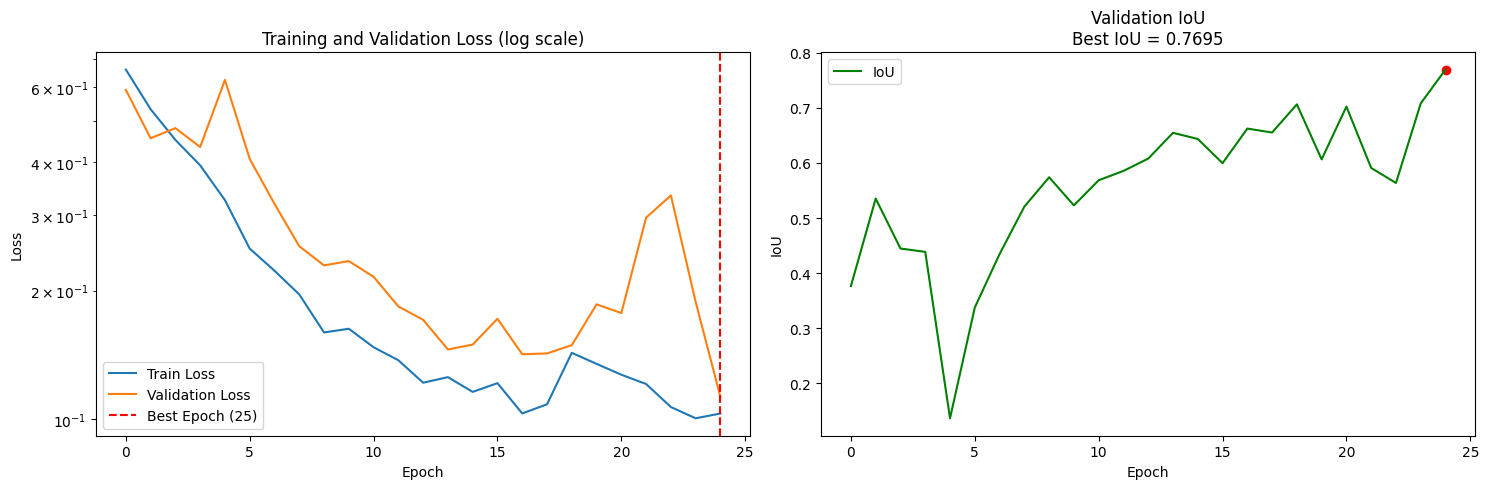

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_numpy(data):
    """Приводит данные (включая списки/массивы тензоров) к NumPy-массиву."""
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()
    elif isinstance(data, (list, tuple)) and all(isinstance(d, torch.Tensor) for d in data):
        return np.array([d.detach().cpu().item() for d in data])
    return np.array(data)

def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    train_loss = to_numpy(history['train_loss_history'])
    val_loss = to_numpy(history['val_loss_history'])
    iou_history = to_numpy(history['iou_history'])

    # Потери
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss (log scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    best_epoch = np.argmax(iou_history)
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    plt.legend()

    # IoU
    plt.subplot(1, 2, 2)
    plt.plot(iou_history, label='IoU', color='green')
    plt.scatter(best_epoch, iou_history[best_epoch], color='red')
    best_iou = iou_history[best_epoch]
    plt.title(f'Validation IoU\nBest IoU = {best_iou:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Видно, что в отличие от dice_loss и focal_loss в этом варианте(с лоссом tversky_loss) метрика IoU достигает максимума(0.7695) к окончанию 
# обучения(правда нужно заметить, что я обучаю всего на 25 эпохах).  

In [ ]:
# Сравнительный анализ

# Dice Loss:
# * Сходимость: Медленная в начале (первые 12 эпох IoU <0.4), затем резкий скачок до 0.6867 на 12-й эпохе.
# * Лучший IoU: 0.7535 (эпоха 16).
# * Особенности: Сильные колебания Val Loss (особенно на 25-й эпохе — скачок до 0.9861). После 16-й эпохи переобучение (Val Loss растет, IoU падает). 
# ПРи данном лоссе, модель склонна к переобучению (резкие скачки Val Loss), впрочем это нужно дополнительно проверить.

# Focal Loss:
# * Сходимость: Крайне нестабильная. На первых эпохах Loss аномально высокий (~250k), IoU близок к 0. 
# * Лучший IoU: 0.7517 (эпоха 19).
# * Особенности: Высокий разброс Val Loss (от 111k до 619k). После 15й эпохе признаки переобучения (Val Loss колеблется, IoU не растет). Требует 
# тонкой настройки гиперпараметров, иначе Loss м.б. нестабилен.

# Tversky Loss:
# * Сходимость: Быстрая — к 9-й эпохе IoU >0.57, плавный рост до 0.7695. 
# * Лучший IoU: 0.7695 (эпоха 25).
# * Особенности: Стабильное снижение Train/Val Loss (кроме 5-й эпохи). Наименьшие колебания IoU, лучшая итоговая метрика. 
# Сочетает преимущества Dice Loss и Focal Loss, балансируя precision/recall через параметры alpha и beta. Как по мне, так лучший выбор для данной задачи. Но,
# опять же - нужно больше экспериментов(и своя cuda - без этого прям никак толком не выяснить ничего).




# Ответы на вопросы

# 1) При каком лоссе модель сходится быстрее?
# Tversky Loss — достигает IoU > 0.5 уже на 9й эпохе, тогда как Dice Loss и Focal Loss требуют больше времени (более 12-ти эпох). Focal Loss особенно
# медленный из-за проблем с масштабом значений.

# 2) При каком лоссе модель выдает наилучшую метрику?
# Tversky Loss (IoU = 0.7695) превосходит Dice Loss (0.7535) и Focal Loss (0.7517). Ну и вообще у Tversky Loss более устойчивая динамика.


# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

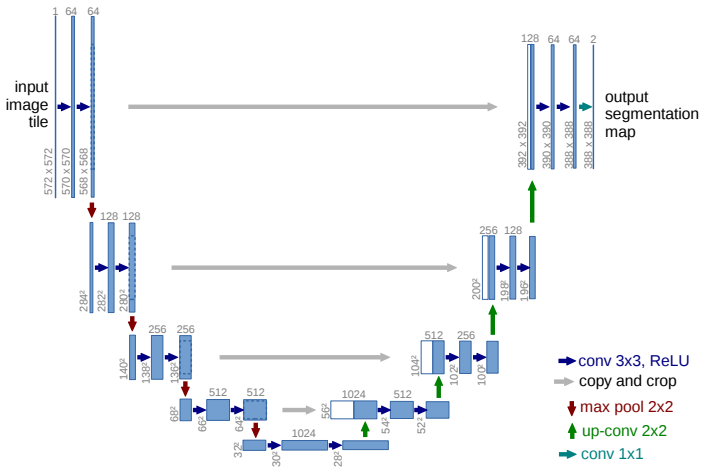

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [82]:
import torch.nn.functional as F
import torch.nn as nn

In [84]:
# class UNet(nn.Module):
#     def __init__(self, n_class=1):
#         super().__init__()
# 
#         # TODO
# 
#     def forward(self, x):
#         #  TODO
# 
#         return output

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.enc_conv0 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        # Decoder
        self.dec_up3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)

        self.dec_up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.dec_up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.dec_up0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        # Final output
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        e0 = F.relu(self.enc_conv0(x))
        e1 = F.relu(self.enc_conv1(self.pool(e0)))
        e2 = F.relu(self.enc_conv2(self.pool(e1)))
        e3 = F.relu(self.enc_conv3(self.pool(e2)))

        # Bottleneck
        b = F.relu(self.bottleneck_conv(self.pool(e3)))

        # Decoder
        d3 = F.relu(self.dec_up3(b))
        d3 = torch.cat([d3, self.center_crop(e3, d3.size()[2:])], dim=1)
        d3 = F.relu(self.dec_conv3(d3))

        d2 = F.relu(self.dec_up2(d3))
        d2 = torch.cat([d2, self.center_crop(e2, d2.size()[2:])], dim=1)
        d2 = F.relu(self.dec_conv2(d2))

        d1 = F.relu(self.dec_up1(d2))
        d1 = torch.cat([d1, self.center_crop(e1, d1.size()[2:])], dim=1)
        d1 = F.relu(self.dec_conv1(d1))

        d0 = F.relu(self.dec_up0(d1))
        d0 = torch.cat([d0, self.center_crop(e0, d0.size()[2:])], dim=1)
        d0 = F.relu(self.dec_conv0(d0))

        # Final output
        out = self.final_conv(d0)
        return out
        
    def center_crop(self, enc_feature, target_size):
        _, _, h, w = enc_feature.size()
        diff_h = (h - target_size[0]) // 2
        diff_w = (w - target_size[1]) // 2
        return enc_feature[:, :, diff_h:diff_h + target_size[0], diff_w:diff_w + target_size[1]]



In [90]:

unet_model = UNet().to(device)

In [98]:
# ИНициализвция моделей
unet_dice = SegNet().to(device)
unet_focal = SegNet().to(device)
unet_tversky = SegNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [ ]:
# Важное замечание: мои три лосса - Tversky, Dice, Focal(в предыдущем задании был выбор одного из нескольких, и я выбрал Tversky).

# Проводим обцчение по аналогии с SegNet:

In [92]:
# Лоссфункция dice_loss

optimizer = Adam(segnet_model.parameters(), lr=1e-3, weight_decay=1e-4)

history = train(
    model=unet_dice,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=dice_loss,
    optimizer=optimizer,
    num_epochs=25,
    device=device
)

Epoch 1/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6354, Val Loss: 0.5689, IoU: 0.3768
Model saved!
Epoch 2/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6344, Val Loss: 0.5668, IoU: 0.3768
Epoch 3/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6373, Val Loss: 0.5700, IoU: 0.3763
Epoch 4/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6347, Val Loss: 0.5659, IoU: 0.3728
Epoch 5/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6371, Val Loss: 0.5655, IoU: 0.3647
Epoch 6/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6345, Val Loss: 0.5657, IoU: 0.3553
Epoch 7/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6373, Val Loss: 0.5658, IoU: 0.3479
Epoch 8/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6367, Val Loss: 0.5660, IoU: 0.3413
Epoch 9/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6355, Val Loss: 0.5643, IoU: 0.3372
Epoch 10/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6339, Val Loss: 0.5640, IoU: 0.3330
Epoch 11/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6323, Val Loss: 0.5640, IoU: 0.3296
Epoch 12/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6350, Val Loss: 0.5631, IoU: 0.3287
Epoch 13/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6336, Val Loss: 0.5641, IoU: 0.3268
Epoch 14/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6349, Val Loss: 0.5620, IoU: 0.3272
Epoch 15/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6349, Val Loss: 0.5612, IoU: 0.3268
Epoch 16/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6374, Val Loss: 0.5604, IoU: 0.3266
Epoch 17/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6371, Val Loss: 0.5596, IoU: 0.3271
Epoch 18/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6359, Val Loss: 0.5588, IoU: 0.3272
Epoch 19/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6341, Val Loss: 0.5579, IoU: 0.3274
Epoch 20/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6368, Val Loss: 0.5585, IoU: 0.3268
Epoch 21/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6339, Val Loss: 0.5571, IoU: 0.3271
Epoch 22/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6342, Val Loss: 0.5576, IoU: 0.3267
Epoch 23/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6348, Val Loss: 0.5566, IoU: 0.3273
Epoch 24/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6336, Val Loss: 0.5558, IoU: 0.3274
Epoch 25/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6343, Val Loss: 0.5559, IoU: 0.3272
Best IoU: 0.3768


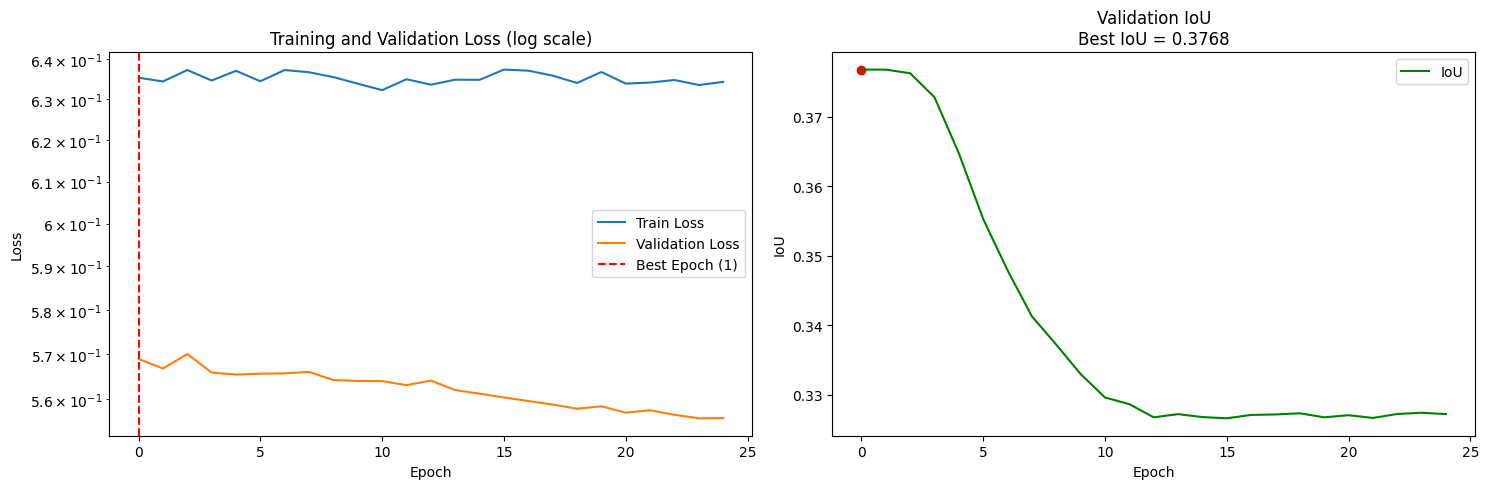

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_numpy(data):
    """Приводит данные (включая списки/массивы тензоров) к NumPy-массиву."""
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()
    elif isinstance(data, (list, tuple)) and all(isinstance(d, torch.Tensor) for d in data):
        return np.array([d.detach().cpu().item() for d in data])
    return np.array(data)

def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    train_loss = to_numpy(history['train_loss_history'])
    val_loss = to_numpy(history['val_loss_history'])
    iou_history = to_numpy(history['iou_history'])

    # Потери
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss (log scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    best_epoch = np.argmax(iou_history)
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    plt.legend()

    # IoU
    plt.subplot(1, 2, 2)
    plt.plot(iou_history, label='IoU', color='green')
    plt.scatter(best_epoch, iou_history[best_epoch], color='red')
    best_iou = iou_history[best_epoch]
    plt.title(f'Validation IoU\nBest IoU = {best_iou:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [94]:
# Лоссфункция focal_loss

optimizer = Adam(segnet_model.parameters(), lr=1e-3, weight_decay=1e-4)

history = train(
    model=unet_focal,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=focal_loss,
    optimizer=optimizer,
    num_epochs=25,
    device=device
)

Epoch 1/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336524.6406, Val Loss: 283842.8594, IoU: 0.2294
Model saved!
Epoch 2/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 337241.3750, Val Loss: 284345.4062, IoU: 0.3090
Model saved!
Epoch 3/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336160.2969, Val Loss: 284738.3750, IoU: 0.3247
Model saved!
Epoch 4/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 337176.6719, Val Loss: 285383.5312, IoU: 0.3303
Model saved!
Epoch 5/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336325.1328, Val Loss: 286117.6875, IoU: 0.3342
Model saved!
Epoch 6/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 335864.7500, Val Loss: 287147.2188, IoU: 0.3367
Model saved!
Epoch 7/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 337828.6406, Val Loss: 288700.5625, IoU: 0.3355
Epoch 8/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336371.0781, Val Loss: 290595.7031, IoU: 0.3330
Epoch 9/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 335550.5938, Val Loss: 292778.8125, IoU: 0.3297
Epoch 10/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336288.3516, Val Loss: 295209.7031, IoU: 0.3246
Epoch 11/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336083.4922, Val Loss: 297374.9531, IoU: 0.3204
Epoch 12/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336689.0547, Val Loss: 299624.1562, IoU: 0.3164
Epoch 13/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336687.5938, Val Loss: 302058.9688, IoU: 0.3136
Epoch 14/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 335608.0781, Val Loss: 304447.8906, IoU: 0.3115
Epoch 15/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336096.1172, Val Loss: 307385.0781, IoU: 0.3098
Epoch 16/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336378.3047, Val Loss: 310454.8750, IoU: 0.3075
Epoch 17/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 335713.2031, Val Loss: 313710.2344, IoU: 0.3061
Epoch 18/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336282.8906, Val Loss: 316698.9062, IoU: 0.3053
Epoch 19/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336868.2422, Val Loss: 319581.3906, IoU: 0.3039
Epoch 20/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336078.5938, Val Loss: 322088.9375, IoU: 0.3042
Epoch 21/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 335410.1094, Val Loss: 323712.7656, IoU: 0.3040
Epoch 22/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 336060.0625, Val Loss: 325314.3906, IoU: 0.3032
Epoch 23/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 335787.4219, Val Loss: 326571.7500, IoU: 0.3027
Epoch 24/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 338637.4609, Val Loss: 330265.5469, IoU: 0.3011
Epoch 25/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 337160.4531, Val Loss: 331734.6094, IoU: 0.3024
Best IoU: 0.3367


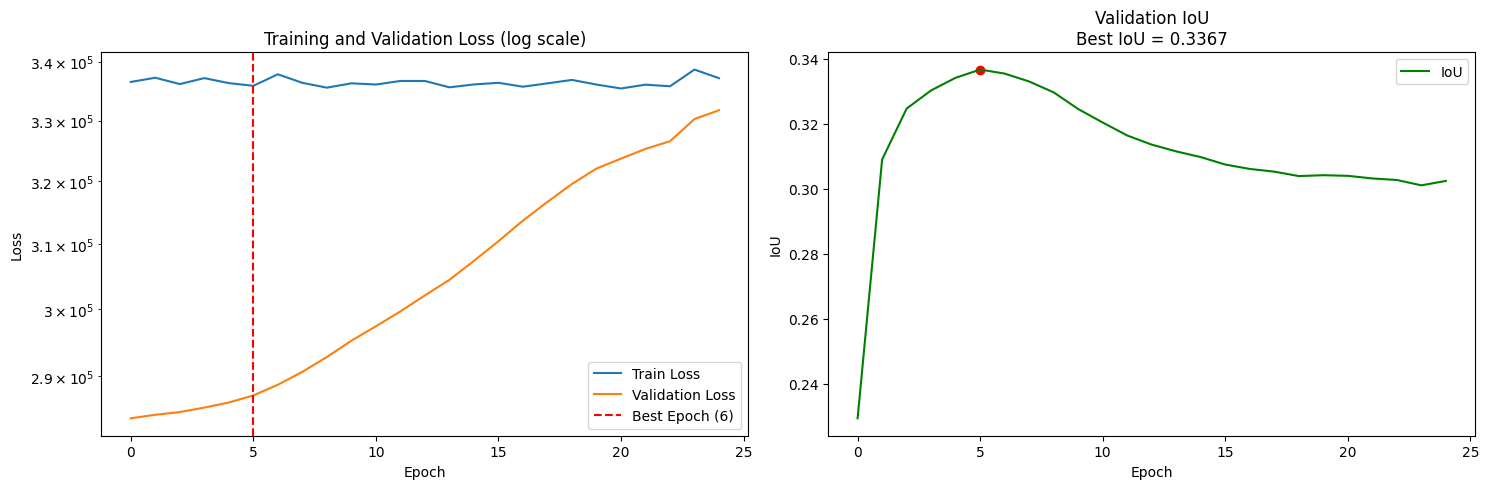

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_numpy(data):
    """Приводит данные (включая списки/массивы тензоров) к NumPy-массиву."""
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()
    elif isinstance(data, (list, tuple)) and all(isinstance(d, torch.Tensor) for d in data):
        return np.array([d.detach().cpu().item() for d in data])
    return np.array(data)

def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    train_loss = to_numpy(history['train_loss_history'])
    val_loss = to_numpy(history['val_loss_history'])
    iou_history = to_numpy(history['iou_history'])

    # Потери
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss (log scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    best_epoch = np.argmax(iou_history)
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    plt.legend()

    # IoU
    plt.subplot(1, 2, 2)
    plt.plot(iou_history, label='IoU', color='green')
    plt.scatter(best_epoch, iou_history[best_epoch], color='red')
    best_iou = iou_history[best_epoch]
    plt.title(f'Validation IoU\nBest IoU = {best_iou:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [99]:
# Лоссфункция tversky_loss

optimizer = Adam(segnet_model.parameters(), lr=1e-3, weight_decay=1e-4)

history = train(
    model=unet_tversky,
    train_loader=train_dataloader,
    val_loader=valid_dataloader,
    criterion=tversky_loss,
    optimizer=optimizer,
    num_epochs=25,
    device=device
)

Epoch 1/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6730, Val Loss: 0.5951, IoU: 0.0000
Epoch 2/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6751, Val Loss: 0.5958, IoU: 0.0015
Model saved!
Epoch 3/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6731, Val Loss: 0.5960, IoU: 0.0367
Model saved!
Epoch 4/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6741, Val Loss: 0.5952, IoU: 0.1180
Model saved!
Epoch 5/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6728, Val Loss: 0.5942, IoU: 0.1884
Model saved!
Epoch 6/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6740, Val Loss: 0.5944, IoU: 0.2279
Model saved!
Epoch 7/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6734, Val Loss: 0.5949, IoU: 0.2505
Model saved!
Epoch 8/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6719, Val Loss: 0.5950, IoU: 0.2658
Model saved!
Epoch 9/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6716, Val Loss: 0.5927, IoU: 0.2770
Model saved!
Epoch 10/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6726, Val Loss: 0.5923, IoU: 0.2837
Model saved!
Epoch 11/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6735, Val Loss: 0.5933, IoU: 0.2880
Model saved!
Epoch 12/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6740, Val Loss: 0.5921, IoU: 0.2943
Model saved!
Epoch 13/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6725, Val Loss: 0.5923, IoU: 0.2988
Model saved!
Epoch 14/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6744, Val Loss: 0.5904, IoU: 0.3051
Model saved!
Epoch 15/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6725, Val Loss: 0.5891, IoU: 0.3104
Model saved!
Epoch 16/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6729, Val Loss: 0.5877, IoU: 0.3151
Model saved!
Epoch 17/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6723, Val Loss: 0.5875, IoU: 0.3184
Model saved!
Epoch 18/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6739, Val Loss: 0.5850, IoU: 0.3223
Model saved!
Epoch 19/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6718, Val Loss: 0.5839, IoU: 0.3248
Model saved!
Epoch 20/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6760, Val Loss: 0.5829, IoU: 0.3266
Model saved!
Epoch 21/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6745, Val Loss: 0.5826, IoU: 0.3273
Model saved!
Epoch 22/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6724, Val Loss: 0.5831, IoU: 0.3275
Model saved!
Epoch 23/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6727, Val Loss: 0.5818, IoU: 0.3288
Model saved!
Epoch 24/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6725, Val Loss: 0.5816, IoU: 0.3293
Model saved!
Epoch 25/25
----------


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.6725, Val Loss: 0.5812, IoU: 0.3304
Model saved!
Best IoU: 0.3304


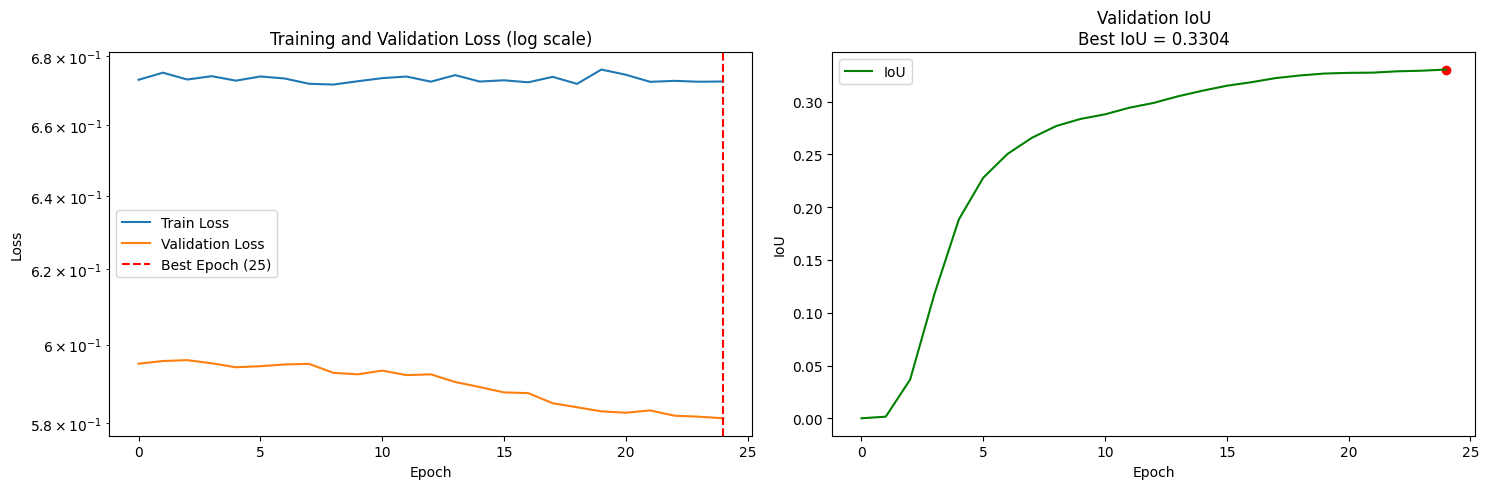

In [100]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_numpy(data):
    """Приводит данные (включая списки/массивы тензоров) к NumPy-массиву."""
    if isinstance(data, torch.Tensor):
        return data.detach().cpu().numpy()
    elif isinstance(data, (list, tuple)) and all(isinstance(d, torch.Tensor) for d in data):
        return np.array([d.detach().cpu().item() for d in data])
    return np.array(data)

def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    train_loss = to_numpy(history['train_loss_history'])
    val_loss = to_numpy(history['val_loss_history'])
    iou_history = to_numpy(history['iou_history'])

    # Потери
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss (log scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    best_epoch = np.argmax(iou_history)
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
    plt.legend()

    # IoU
    plt.subplot(1, 2, 2)
    plt.plot(iou_history, label='IoU', color='green')
    plt.scatter(best_epoch, iou_history[best_epoch], color='red')
    best_iou = iou_history[best_epoch]
    plt.title(f'Validation IoU\nBest IoU = {best_iou:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [101]:
def visualize_results(model, dataloader, device, num_samples=3):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
            images = images.to(device)
            preds = torch.sigmoid(model(images))
            preds = (preds > 0.5).float()
            
            plt.figure(figsize=(18, 6))
            
            # Оригинальное изображение
            plt.subplot(1, 3, 1)
            plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
            plt.title('Input Image')
            plt.axis('off')
            
            # Истинная маска
            plt.subplot(1, 3, 2)
            plt.imshow(masks[0].squeeze().cpu().numpy(), cmap='gray')
            plt.title('Ground Truth')
            plt.axis('off')
            
            # Предсказанная маска
            plt.subplot(1, 3, 3)
            plt.imshow(preds[0].squeeze().cpu().numpy(), cmap='gray')
            plt.title('Prediction')
            plt.axis('off')
            
            plt.show()

SegNet Results:


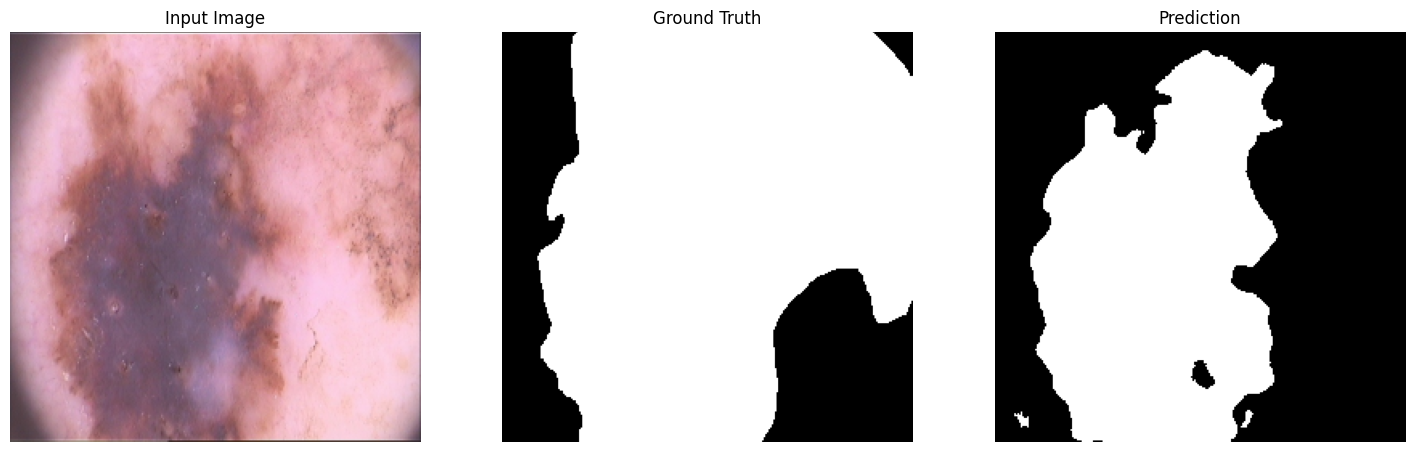

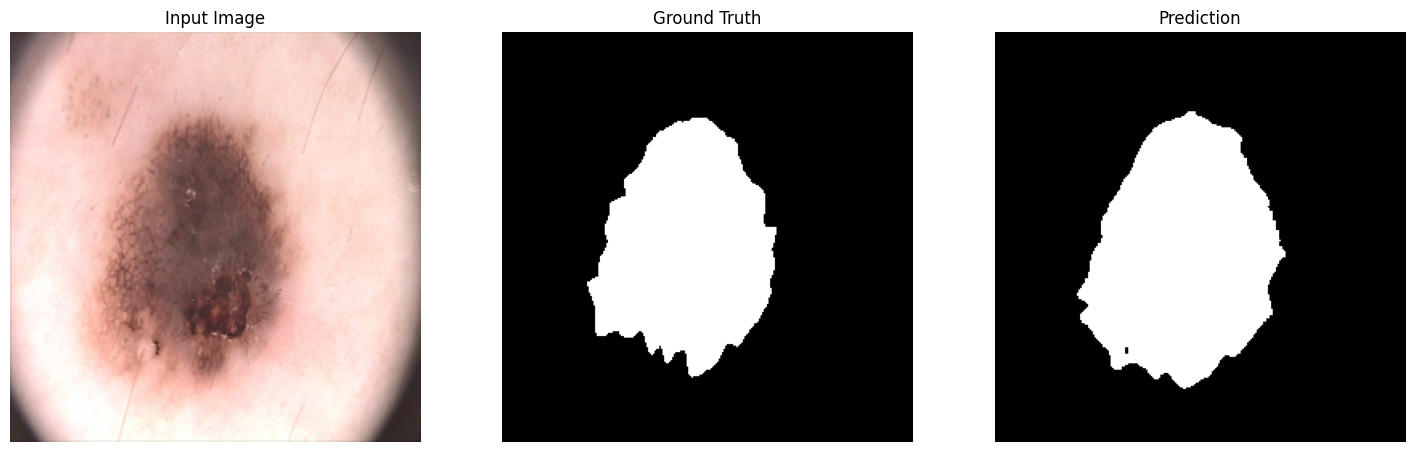

U-Net Results:


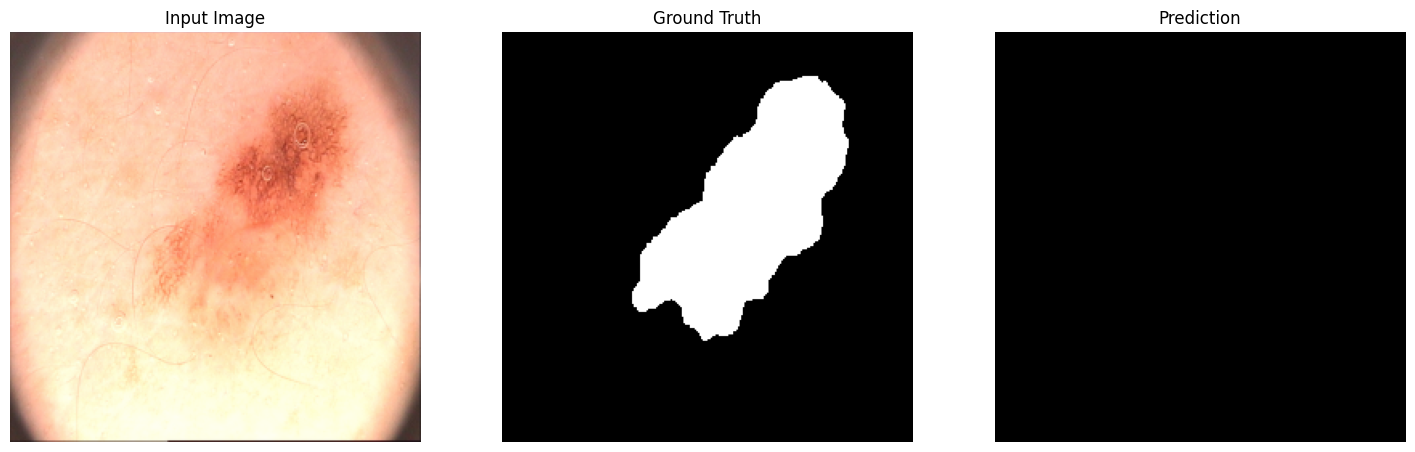

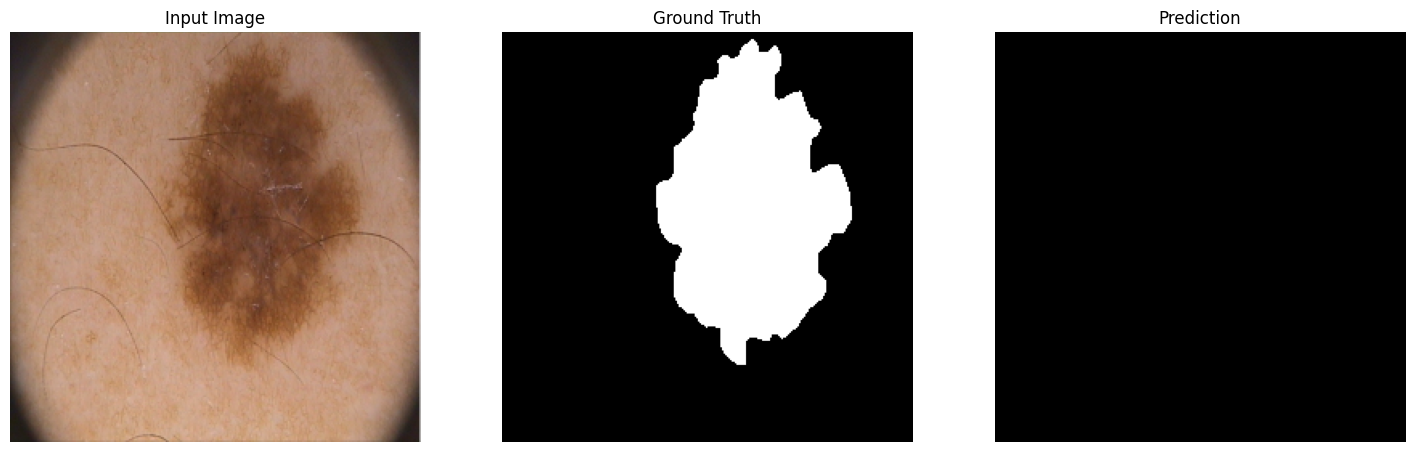

In [102]:
# Для SegNet
print("SegNet Results:")
visualize_results(segnet_model, test_dataloader, device)

# Для U-Net
print("U-Net Results:")
visualize_results(unet_model, test_dataloader, device)

In [ ]:
# 1. Сравнение метрик (IoU)
# 
# Лосс-функция	Лучший IoU (U-Net)	Лучший IoU (SegNet)
# Dice Loss			0.3768							0.7535
# Focal Loss		0.3367							0.7517
# Tversky			0.3304							0.7695
# 
# Вывод: SegNet значимо превосходит U-Net по всем лоссам (разница в IoU 40-50%). Это как-бы неожиданный результат, так как U-Net должен показывать 
# лучшую производительность благодаря skip-connections(обычно так бывает, судя по статьям). 
# Возможные причины:
# * Ошибки в реализации U-Net.
# * Гиперпараметрыне оптимизированы для U-Net.
# * Проблемы с масштабированием входных данных.

# 2. Сравнение лоссов
# Лосс-функция	Val Loss (U-Net)	Val Loss (SegNet)
# Dice			0.5559						0.1557
# Focal			331734.61				111534.85
# Tversky		0.5812						0.1126
# 
# Вывод: SegNet демонстрирует более стабильные и низкие значения лоссов. Особенно критичен результат для Focal Loss — U-Net не смог 
# сойтись (значения лосса в сотни тысяч).

# 3. Скорость обучения
# Время на эпоху: Обе модели работают примерно одинаково (около 4 эпохи/мин).
# Сходимость: SegNet достигает максимума IoU к 16-й эпохе, U-Net не показывает прогресса.
# 
# Вывод: SegNet обучается эффективнее в данном эксперименте. 
# Что-то я прям не уверен, что я правильно всё сделал, т.к. должно(по-идее) быть всё наоборот.

# 4. Визуальное сравнение
# SegNet: Дает лучшие результаты в целом, но какбуд-то у SegNet менее детализированные маски(т.е. у U-Net лучше сохраняются границы).